Import result scores.

In [1]:
import csv
def read_results(csv_fname):
    with open("../%s" % csv_fname, "rt") as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader) # ignore the header
        for row in reader:
            yield (tuple(row[0].split("-", 8)), float(row[1]))

In [2]:
datasets = ("test-2016", "dev", "test-2017")
results = {}
results["dev"] = dict(read_results("results-dev.csv"))
results["test-2016"] = dict(read_results("results-2016.csv"))
results["test-2017"] = dict(read_results("results-2017.csv"))

Import matrix densities.

In [3]:
from glob import glob
from math import sqrt
import re
FNAME_SUFFIX = ".log"
M = 466585
def read_densities(fname_prefix):
    densities = {}
    for log_fname in glob("%s*%s" % (fname_prefix, FNAME_SUFFIX)):
        config = tuple(re.split("-{1}", log_fname.replace(fname_prefix, "").replace(FNAME_SUFFIX, "")))
        density = !sed -r -n '/by thresholding/s/- ([0-9.]*).*/\1/p' $log_fname
        k = sqrt(float(density[0]) * M**2) # average number of non-zero elements per row / column
        densities[config] =  (k**2 - M) / M**2 # account for the fact that we don't need to store the diagonal
    return densities

In [4]:
densities = {}
densities["mrel"] = read_densities("../datasets/QL-unannotated-data-subtaskA.Mrel-w2v.ql-") 
densities["mlev"] = read_densities("../datasets/QL-unannotated-data-subtaskA.Mlev-")

Load the plotting libraries.

In [5]:
%matplotlib inline
from matplotlib.pyplot import grid, legend, plot, savefig, show, xlim, xticks, ylim, xticks, xlabel, \
    ylabel, figure, axvline, axhline, xscale
linestyles = ['-o', '-x', '-^']
colors = [(r/255., g/255., b/255.) for (r, g, b) in [(31, 119, 180), (255, 127, 14), (44, 160, 44)]]
xlims = (0.0000003, 0.01)
figsize=(7, 3.5)

# MAP-density plots
## Matrix $\mathbf S_{\textrm{rel}}$

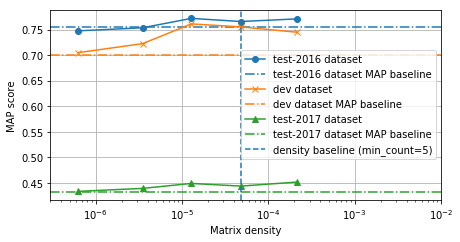

In [6]:
figure(figsize=figsize)
for dataset_num, dataset in enumerate(datasets):
    X = []
    Y = []
    for w2v_min_count in (0, 5, 50, 500, 5000):
        density = densities["mrel"][(str(w2v_min_count), "100", "0.000000", "2.000000")]
        map_score = results[dataset][("soft_terms", "w2v.ql", "mrel", "early", "soft", "none",
                                      str(w2v_min_count), "100", "0.0")]
        X.append(density)
        Y.append(map_score)
    plot(X, Y, linestyles[dataset_num], color=colors[dataset_num], label="%s dataset" % dataset)
    axhline(results[dataset][("hard_terms",)], linestyle='-.', color=colors[dataset_num],
            label="%s dataset MAP baseline" % dataset)
axvline(densities["mrel"][("5", "100", "0.000000", "2.000000")], linestyle='--',
        label="density baseline (min_count=5)")
xscale("log")
xlim(xlims)
xlabel("Matrix density")
ylabel("MAP score")
legend()
grid(True)
savefig("fig1.pdf")

Figure 1: The MAP score of soft terms (early weighting, soft normalization, no rounding) plotted against the density of the term similarity matrix $\mathbf S_{\textrm{rel}}$ as we hold the parameters $C=100$, and $\theta_3=0.0$ constant and decrease the parameter `min_count` from the value of 5000 (leftmost) to the value of 0 (rightmost) by factors of ten. For every dataset, the baseline MAP score corresponding to hard cosine similarity on terms is displayed for comparison. The baseline density corresponds to the parameter `min_count=5` used by Charlet and Damnati, 2017.

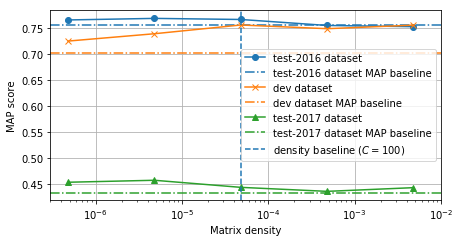

In [7]:
figure(figsize=figsize)
for dataset_num, dataset in enumerate(datasets):
    X = []
    Y = []
    for w2v_knn in (1, 10, 100, 1000, 10000):
        density = densities["mrel"][("5", str(w2v_knn), "0.000000", "2.000000")]
        map_score = results[dataset][("soft_terms", "w2v.ql", "mrel", "early", "soft", "none",
                                      "5", str(w2v_knn), "0.0")]
        X.append(density)
        Y.append(map_score)
    plot(X, Y, linestyles[dataset_num], color=colors[dataset_num], label="%s dataset" % dataset)
    axhline(results[dataset][("hard_terms",)], linestyle='-.', color=colors[dataset_num],
            label="%s dataset MAP baseline" % dataset)
axvline(densities["mrel"][("5", "100", "0.000000", "2.000000")], linestyle='--',
        label="density baseline ($C=100$)")
xscale("log")
xlim(xlims)
xlabel("Matrix density")
ylabel("MAP score")
legend()
grid(True)
savefig("fig2.pdf")

Figure 2: The MAP score of soft terms (early weighting, soft normalization, no rounding) plotted against the density of the term similarity matrix $\mathbf S_{\textrm{rel}}$ as we hold the parameters `w2v_min_count=5`, and $\theta_3=0.0$ constant and increase the parameter $C$ from the value of 1 (leftmost) to the value of 10,000 (rightmost) by factors of ten. For every dataset, the baseline MAP score corresponding to hard cosine similarity on terms is displayed for comparison. The baseline density corresponds to the parameter $C=100$ used by Charlet and Damnati, 2017.

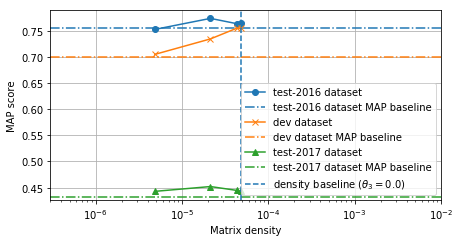

In [8]:
figure(figsize=figsize)
for dataset_num, dataset in enumerate(datasets):
    X = []
    Y = []
    for m_threshold in (0.2, 0.4, 0.6, 0.8):
        density = densities["mrel"][("5", "100", "%f" % m_threshold, "2.000000")]
        map_score = results[dataset][("soft_terms", "w2v.ql", "mrel", "early", "soft", "none",
                                      "5", "100", str(m_threshold))]
        X.append(density)
        Y.append(map_score)
    plot(X, Y, linestyles[dataset_num], color=colors[dataset_num], label="%s dataset" % dataset)
    axhline(results[dataset][("hard_terms",)], linestyle='-.', color=colors[dataset_num],
            label="%s dataset MAP baseline" % dataset)
axvline(densities["mrel"][("5", "100", "0.000000", "2.000000")], linestyle='--',
        label="density baseline ($\\theta_3=0.0$)")
xscale("log")
xlim(xlims)
xlabel("Matrix density")
ylabel("MAP score")
legend()
grid(True)
savefig("fig3.pdf")

Figure 3: The MAP score of soft terms (early weighting, soft normalization, no rounding) plotted against the density of the term similarity matrix $\mathbf S_{\textrm{rel}}$ as we hold the parameters `w2v_min_count=5`, and $C=100$ constant and decrease the parameter $\theta_3$ from the value of 0.8 (leftmost) to the value of 0.2 (rightmost) by 0.2 at each step. For every dataset, the baseline MAP score corresponding to hard cosine similarity on terms is displayed for comparison. The baseline density corresponds to the parameter $\theta_3=0.0$ used by Charlet and Damnati, 2017; notice that the matrix $\mathbf S_{\textrm{rel}}$ contains no entries below 0.2.

## Matrix $\mathbf S_{\textrm{lev}}$

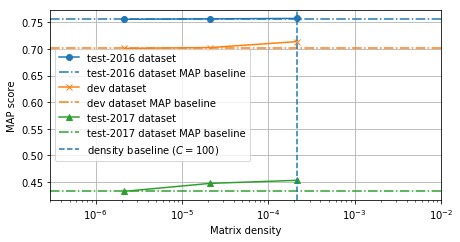

In [9]:
figure(figsize=figsize)
for dataset_num, dataset in enumerate(datasets):
    X = []
    Y = []
    for w2v_knn in (1, 10, 100):
        density = densities["mlev"][(str(w2v_knn), "0.000000")]
        map_score = results[dataset][("soft_terms", "w2v.ql", "mlev", "early", "soft", "none",
                                      "5", str(w2v_knn), "0.0")]
        X.append(density)
        Y.append(map_score)
    plot(X, Y, linestyles[dataset_num], color=colors[dataset_num], label="%s dataset" % dataset)
    axhline(results[dataset][("hard_terms",)], linestyle='-.', color=colors[dataset_num],
            label="%s dataset MAP baseline" % dataset)
axvline(densities["mlev"][("100", "0.000000")], linestyle='--',
        label="density baseline ($C=100$)")
xscale("log")
xlim(xlims)
xlabel("Matrix density")
ylabel("MAP score")
legend()
grid(True)
savefig("fig4.pdf")

Figure 4: The MAP score of soft terms (early weighting, soft normalization, no rounding) plotted against the density of the term similarity matrix $\mathbf S_{\textrm{lev}}$ as we hold the parameters `w2v_min_count=5`, and $\theta_3=0.0$ constant and increase the parameter $C$ from the value of 1 (leftmost) to the value of 100 (rightmost) by factors of ten. For every dataset, the baseline MAP score corresponding to hard cosine similarity on terms is displayed for comparison. The baseline density corresponds to the parameter $C=100$ used by Charlet and Damnati, 2017.

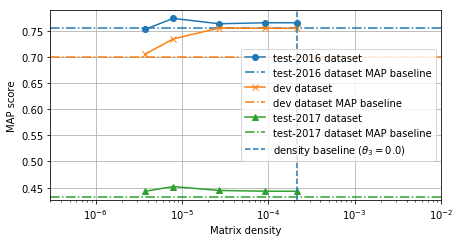

In [10]:
figure(figsize=figsize)
for dataset_num, dataset in enumerate(datasets):
    X = []
    Y = []
    for m_threshold in (0.0, 0.2, 0.4, 0.6, 0.8):
        density = densities["mlev"][("100", "%f" % m_threshold)]
        map_score = results[dataset][("soft_terms", "w2v.ql", "mrel", "early", "soft", "none",
                                      "5", "100", str(m_threshold))]
        X.append(density)
        Y.append(map_score)
    plot(X, Y, linestyles[dataset_num], color=colors[dataset_num], label="%s dataset" % dataset)
    axhline(results[dataset][("hard_terms",)], linestyle='-.', color=colors[dataset_num],
            label="%s dataset MAP baseline" % dataset)
axvline(densities["mlev"][("100", "0.000000")], linestyle='--',
        label="density baseline ($\\theta_3=0.0$)")
xscale("log")
xlim(xlims)
xlabel("Matrix density")
ylabel("MAP score")
legend()
grid(True)
savefig("fig5.pdf")

Figure 5: The MAP score of soft terms (early weighting, soft normalization, no rounding) plotted against the density of the term similarity matrix $\mathbf S_{\textrm{lev}}$ as we hold the parameters `w2v_min_count=5`, and $C=100$ constant and decrease the parameter $\theta_3$ from the value of 0.8 (leftmost) to the value of 0.0 (rightmost) by 0.2 at each step. For every dataset, the baseline MAP score corresponding to hard cosine similarity on terms is displayed for comparison. The baseline density corresponds to the parameter $\theta_3=0.0$ used by Charlet and Damnati, 2017.